### BSTS Model for Chicago Taxi Demand Forecast
Lea Wu | leawu@uchicago.edu

In [329]:
library(lubridate)
library(dplyr)
library(xts)
library(ggplot2)
library(bsts)
library(prophet)
library(nnfor)
library(forecast)
library(fGarch)
library(tseries)

options(repr.plot.width=12, repr.plot.height=6)
options(warn=-1)

### Data preparation

<div class="alert alert-block alert-info"> 
    Aggregate the data into different time scale. Daily data is chose as the target variable
</div>

In [312]:
demand_data <- read.csv("taxi_trip_data.csv")
colnames(demand_data) <- c('trip_cnt','trip_datetime') 
demand_data$trip_datetime <- mdy_hms(demand_data$trip_datetime)
demand_data$rounded_hour <- floor_date(demand_data$trip_datetime, unit = "hour")
demand_data$rounded_day <- floor_date(demand_data$trip_datetime, unit = "day")
demand_data$rounded_month <- floor_date(demand_data$trip_datetime, unit = "month")
demand_data$rounded_year <- floor_date(demand_data$trip_datetime, unit = "year")

In [313]:
head(demand_data, 5)

,trip_cnt,trip_datetime,rounded_hour,rounded_day,rounded_month,rounded_year
,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>
1,87,2023-12-31 23:45:00,2023-12-31 23:00:00,2023-12-31,2023-12-01,2023-01-01
2,108,2023-12-31 23:30:00,2023-12-31 23:00:00,2023-12-31,2023-12-01,2023-01-01
3,87,2023-12-31 23:15:00,2023-12-31 23:00:00,2023-12-31,2023-12-01,2023-01-01
4,99,2023-12-31 23:00:00,2023-12-31 23:00:00,2023-12-31,2023-12-01,2023-01-01
5,107,2023-12-31 22:45:00,2023-12-31 22:00:00,2023-12-31,2023-12-01,2023-01-01


In [314]:
yearly_agg <- demand_data %>%
    group_by(rounded_year) %>%
    summarise(
        trip_cnt = sum(trip_cnt, na.rm = TRUE)
)

In [315]:
monthly_agg <- demand_data %>%
    group_by(rounded_month) %>%
    summarise(
        trip_cnt = sum(trip_cnt, na.rm = TRUE)
)

In [316]:
daily_agg <- demand_data %>%
    group_by(rounded_day) %>%
    summarise(
        trip_cnt = sum(trip_cnt, na.rm = TRUE)
)

In [317]:
hourly_agg <- demand_data %>%
    group_by(rounded_hour) %>%
    summarise(
        trip_cnt = sum(trip_cnt, na.rm = TRUE)
)

### EDA

<div class="alert alert-block alert-info"> 
    Observations:
    <li>COVID brought significant drop to the taxi demand</li>
    <li>Weekly seasonality is observed</li>
    <li>However, the weekly seasonality changed after COVID</li>
    <li>From data around the end of the year, holidays may have significant impact on the time series data</li>
</div>

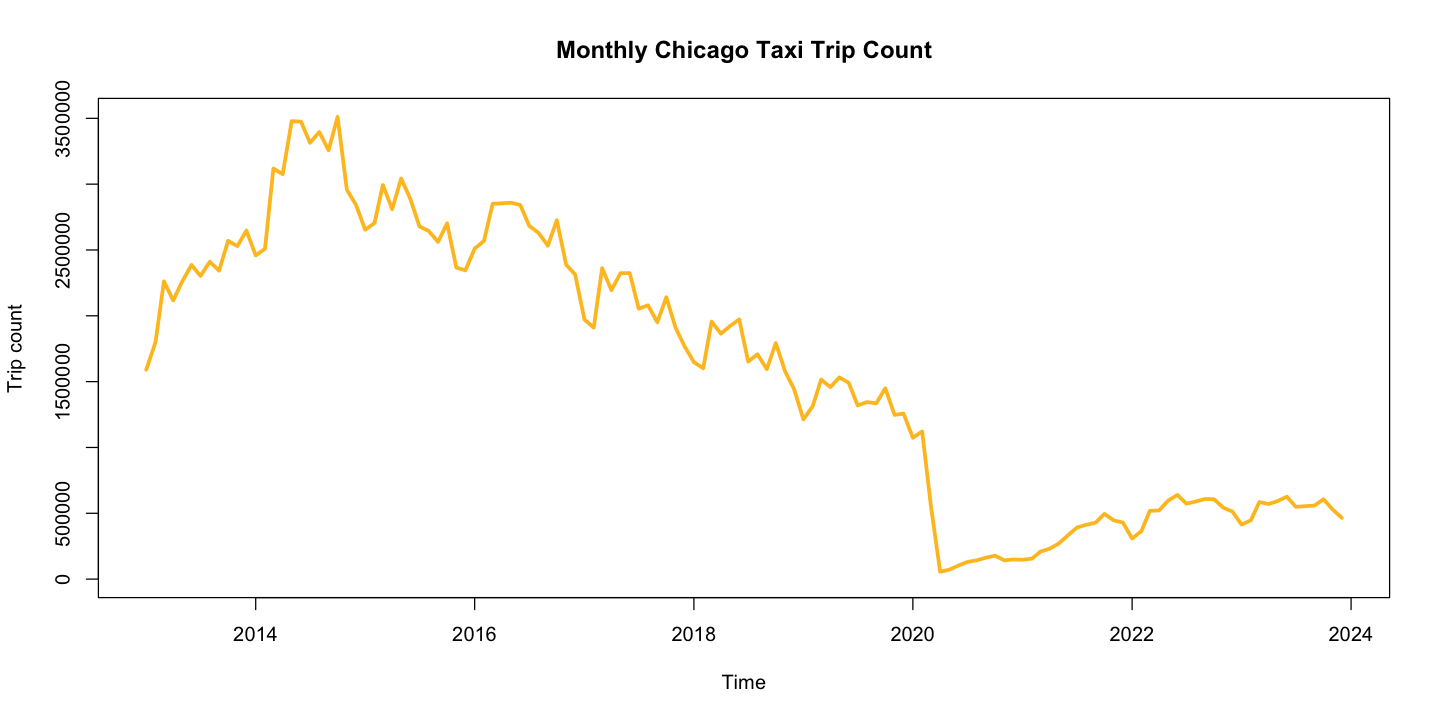

In [318]:
plot(x=monthly_agg$rounded_month, y=monthly_agg$trip_cnt, type ="l", ylab = "Trip count", lwd=3
         , main = "Monthly Chicago Taxi Trip Count", xlab = "Time", col = "goldenrod1", ylim=c(0,max(monthly_agg$trip_cnt)))

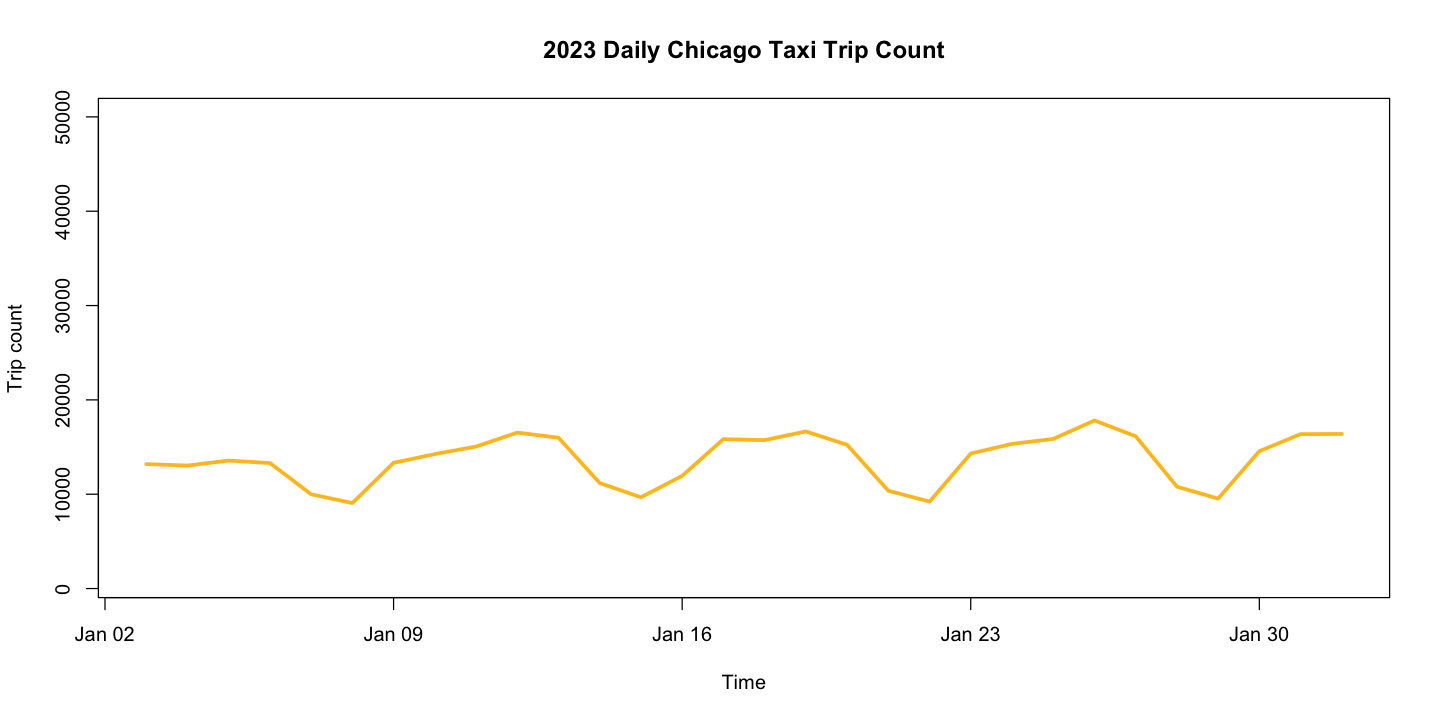

In [319]:
eda_daily <- daily_agg[3655:3684,]
plot(x=eda_daily$rounded_day, y=eda_daily$trip_cnt, type ="l", ylab = "Trip count", lwd=3
         , main = "2023 Daily Chicago Taxi Trip Count", xlab = "Time", col = "goldenrod1", ylim=c(1000,50000))

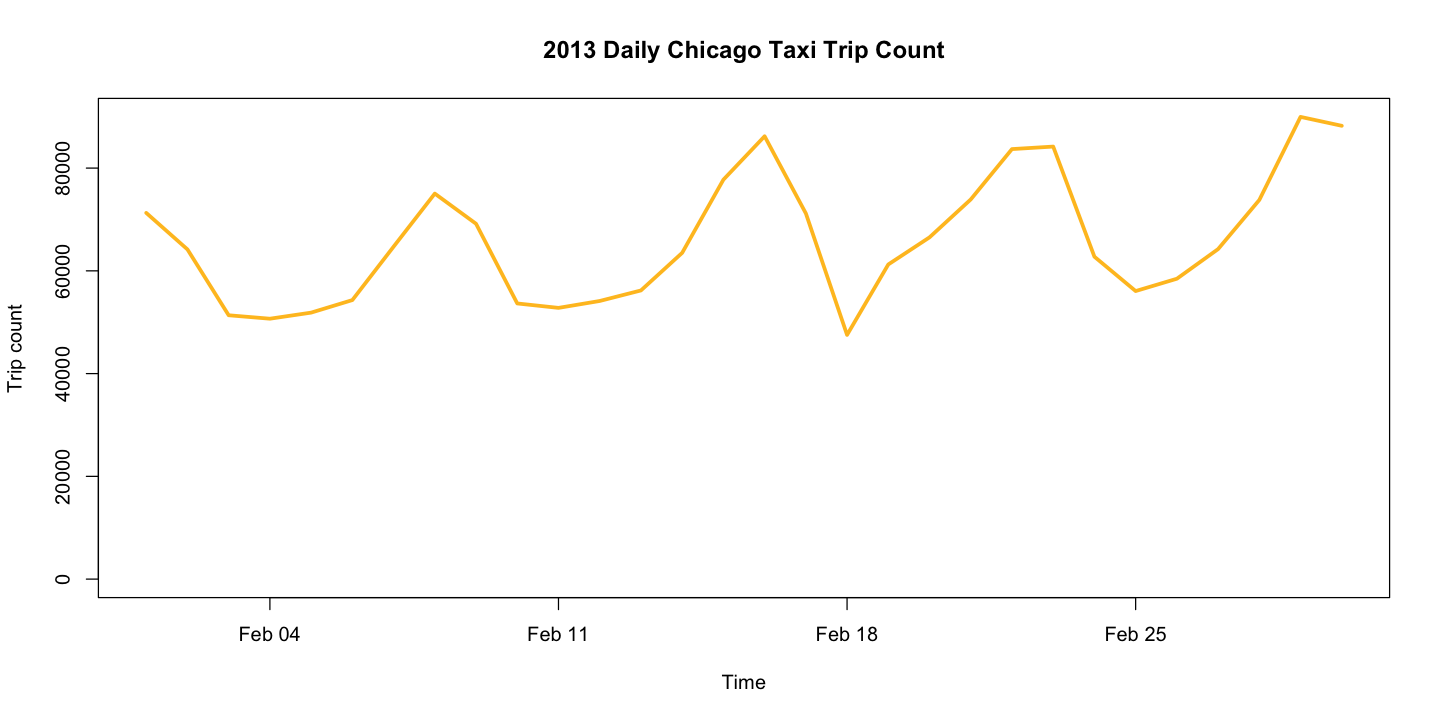

In [321]:
eda_daily <- daily_agg[32:61,]
plot(x=eda_daily$rounded_day, y=eda_daily$trip_cnt, type ="l", ylab = "Trip count", lwd=3
         , main = "2013 Daily Chicago Taxi Trip Count", xlab = "Time", col = "goldenrod1", ylim=c(0,max(eda_daily$trip_cnt)))

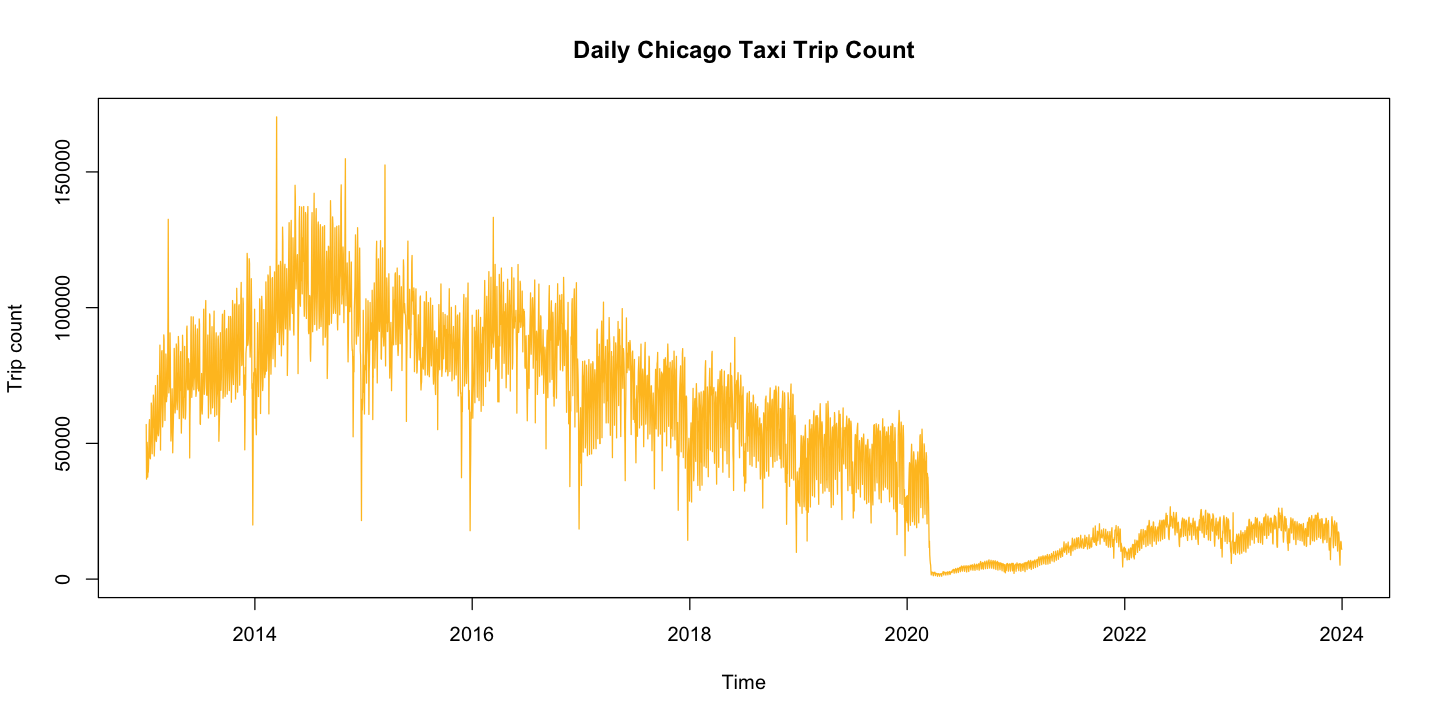

In [322]:
plot(x=daily_agg$rounded_day, y=daily_agg$trip_cnt, type ="l", ylab = "Trip count", lwd=1
         , main = "Daily Chicago Taxi Trip Count", xlab = "Time", col = "goldenrod1", ylim=c(0,max(daily_agg$trip_cnt)))

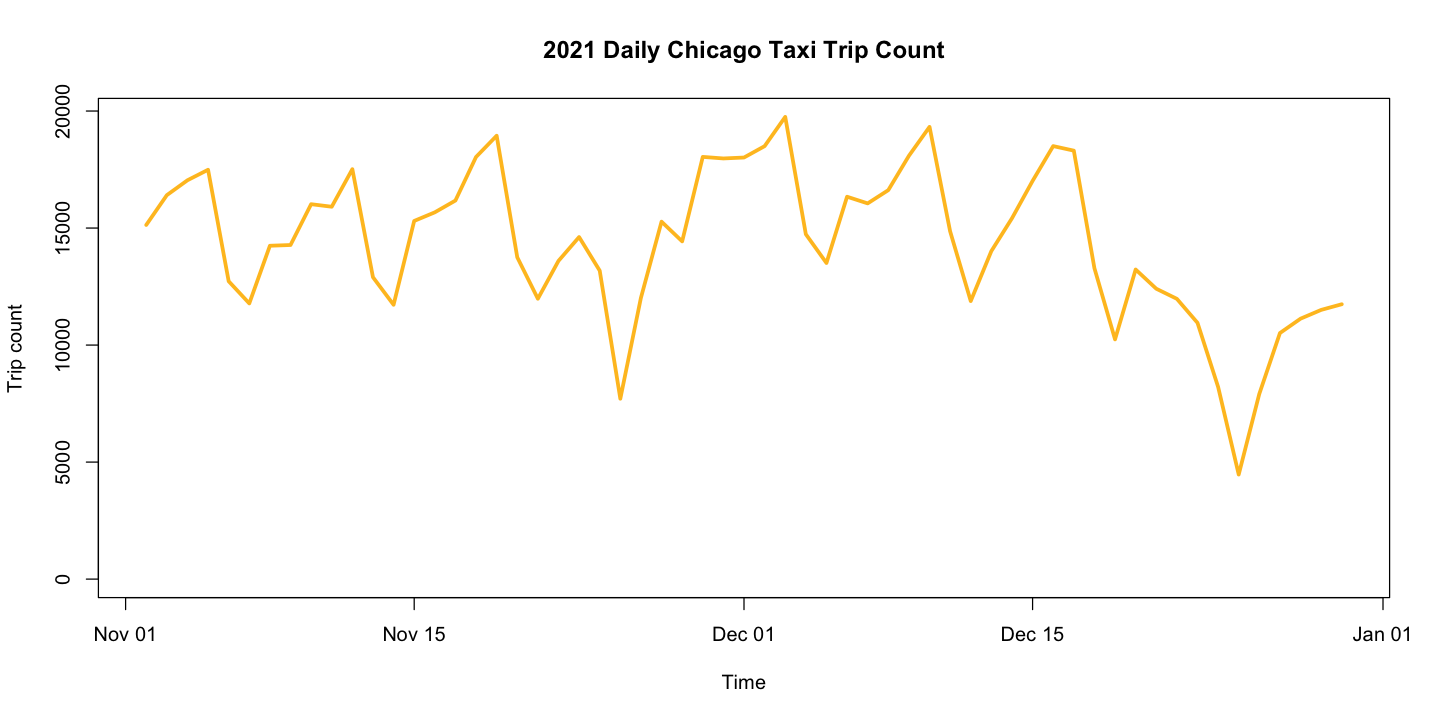

In [323]:
tes <- daily_agg[daily_agg$rounded_day > as.Date("2021-11-01"), ]
tes <- tes[tes$rounded_day <= as.Date("2021-12-30"), ]

plot(x=tes$rounded_day, y=tes$trip_cnt, type ="l", ylab = "Trip count", lwd=3
         , main = "2021 Daily Chicago Taxi Trip Count", xlab = "Time", col = "goldenrod1", ylim=c(0,max(tes$trip_cnt)))

<div class="alert alert-block alert-info"> 
    Though unable to gain aligned conclusion from the result of adf and kpss test, the data plot and the decomposed data suggest that the time series is not stationary
</div>

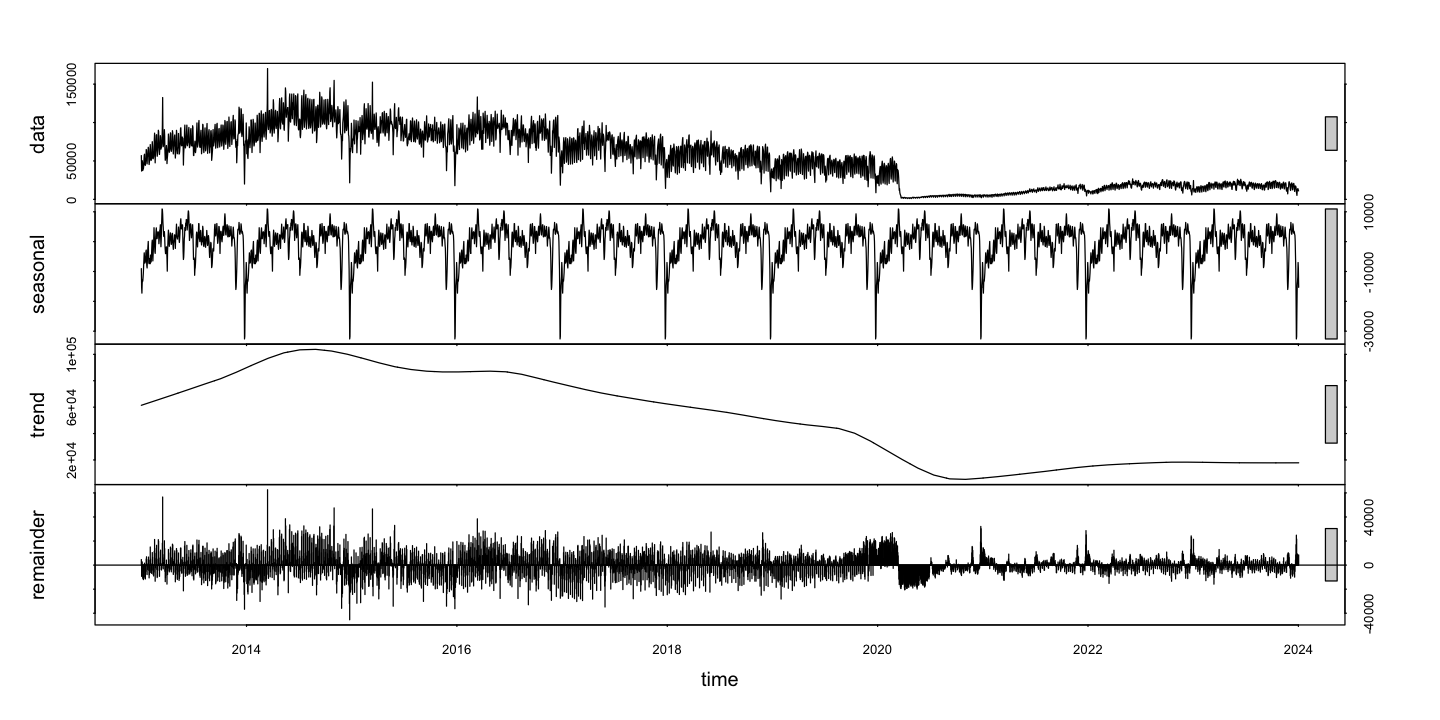

In [324]:
zoo_data <- zoo(daily_agg$trip_cnt, order.by = daily_agg$rounded_day)
start_time <- as.numeric(format(index(zoo_data)[1], "%Y"))
ts_data <- ts(coredata(zoo_data), start = start_time, frequency = 365)
stl_decomposition <- stl(ts_data, s.window = "periodic")
plot(stl_decomposition)

In [356]:
adf.test(zoo_data)


	Augmented Dickey-Fuller Test

data:  zoo_data
Dickey-Fuller = -5.1689, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary


In [357]:
kpss.test(zoo_data)


	KPSS Test for Level Stationarity

data:  zoo_data
KPSS Level = 31.47, Truncation lag parameter = 10, p-value = 0.01


### Data Analysis and Transformation

<div class="alert alert-block alert-info"> 
I only used post-COVID data as training data, since the time series was significantly changed by the pandemic</div>

In [358]:
train <- window(zoo_data, start = as.Date("2020-07-01"), end = as.Date("2023-06-30"))
# train <- window(zoo_data, start = as.Date("2013-01-01"), end = as.Date("2023-06-30"))

test <- window(zoo_data, start = as.Date("2023-07-01"), end = as.Date("2023-12-31"))
train_log <- log(train + 1) 
train_diff <- diff(train, differences = 1)
train_diff_2 <- diff(train, differences = 2)

train_log_diff <- diff(train_log, differences = 1)

<div class="alert alert-block alert-info"> 
    Considering the huge variance in the data and the non-stationary, I tried 3 data transformation: log, differeciate by 1, and differenciate by 2
</div>

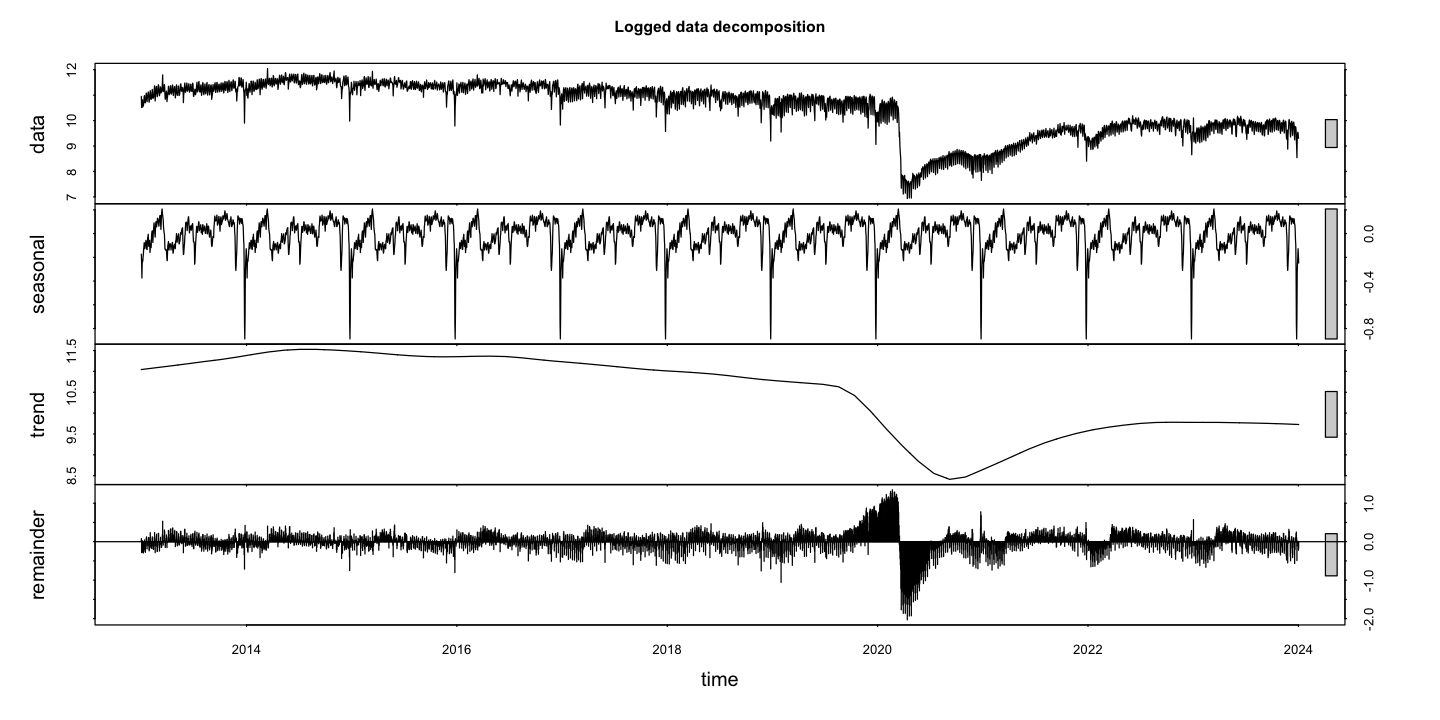

In [326]:
zoo_data_log <- log(zoo_data)
ts_data_log <- ts(coredata(zoo_data_log), start = start_time, frequency = 365)
stl_decomposition_log <- stl(ts_data_log, s.window = "periodic")
plot(stl_decomposition_log, main="Logged data decomposition")

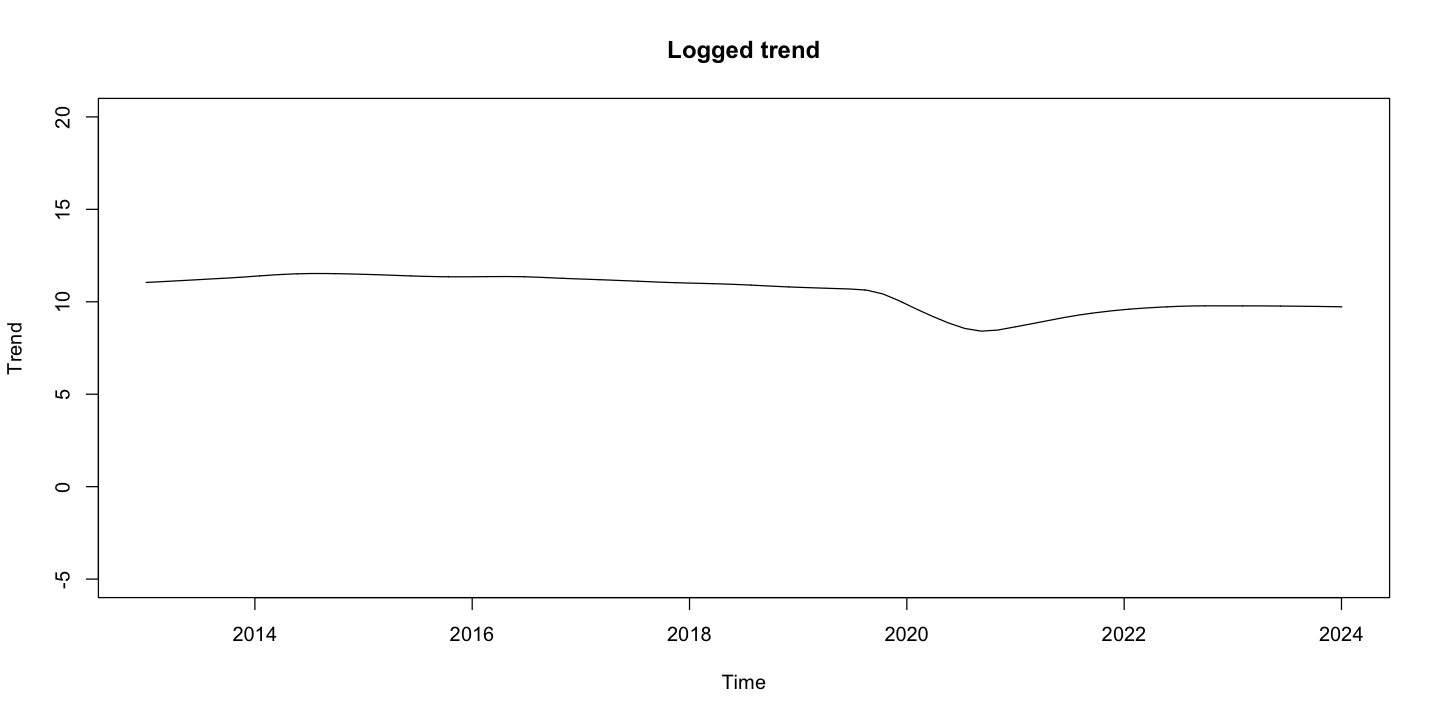

In [327]:
trend_component_log <- stl_decomposition_log$time.series[, "trend"]
plot(trend_component_log, type = "l", ylab = "Trend", ylim = c(-5, 20), main="Logged trend")

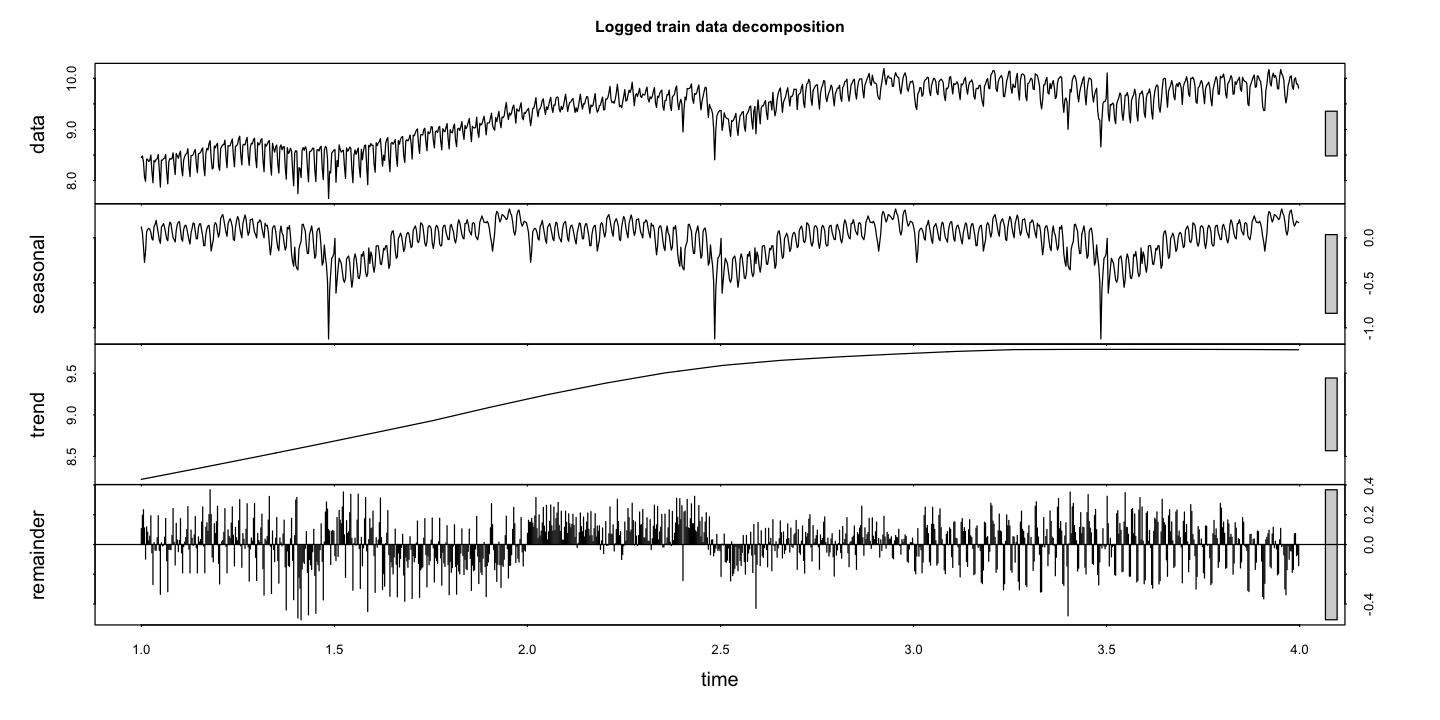

In [328]:
train_ts <- ts(coredata(train_log), frequency = 365)
train_stl_decomposition <- stl(train_ts, s.window = "periodic")
plot(train_stl_decomposition, main="Logged train data decomposition")

##### Log

In [330]:
adf.test(train_log)


	Augmented Dickey-Fuller Test

data:  train_log
Dickey-Fuller = -2.4875, Lag order = 10, p-value = 0.372
alternative hypothesis: stationary


In [331]:
kpss.test(train_log)


	KPSS Test for Level Stationarity

data:  train_log
KPSS Level = 11.116, Truncation lag parameter = 7, p-value = 0.01


##### Differencing

In [332]:
adf.test(train_diff)


	Augmented Dickey-Fuller Test

data:  train_diff
Dickey-Fuller = -16.726, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


In [334]:
kpss.test(train_diff)


	KPSS Test for Level Stationarity

data:  train_diff
KPSS Level = 0.01243, Truncation lag parameter = 7, p-value = 0.1


In [335]:
adf.test(train_diff_2)


	Augmented Dickey-Fuller Test

data:  train_diff_2
Dickey-Fuller = -16.721, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


In [336]:
kpss.test(train_diff_2)


	KPSS Test for Level Stationarity

data:  train_diff_2
KPSS Level = 0.0045273, Truncation lag parameter = 7, p-value = 0.1


<div class="alert alert-block alert-info"> 
    Though the logged data is still non-stationary, it has the best forcast ability in the following model fitting.
</div>

### Model development

<div class="alert alert-block alert-info"> 
Based on the previous hypothesis, I include holidays and major events as regressor in the model
</div>

In [23]:
auto.show <- DateRangeHoliday("Auto_show", start = as.Date(c("2013-02-09", "2014-02-08", "2015-02-14", "2016-02-13", "2017-02-11"
                                                             , "2018-02-10", "2019-02-09", "2020-02-08", "2021-07-15", "2022-02-12"
                                                             , "2023-02-11")), 
                              end = as.Date(c("2013-02-18", "2014-02-17", "2015-02-22", "2016-02-21", "2017-02-20"
                                                , "2018-02-19", "2019-02-18", "2020-02-17"
                                                , "2021-07-19", "2022-02-21", "2023-02-20")))
st.patrick <- DateRangeHoliday("stPatrick", start = as.Date(c("2013/3/16", "2014/3/15", "2015/3/14", "2016/3/12"
                                                              , "2017/3/11", "2018/3/17", "2019/3/16", "2020/3/14"
                                                              , "2021/3/13", "2022/3/12", "2023/3/11")), 
                              end = as.Date(c("2013/3/16", "2014/3/15", "2015/3/14", "2016/3/12"
                                                              , "2017/3/11", "2018/3/17", "2019/3/16", "2020/3/14"
                                                              , "2021/3/13", "2022/3/12", "2023/3/11")))
air.show <- DateRangeHoliday("air_show", start = as.Date(c("2013/8/17", "2014/8/16", "2015/8/15", "2016/8/20"
                                                           , "2017/8/19", "2018/8/18", "2019/8/17"
                                                           , "2021/8/21", "2022/8/20", "2023/8/19")), 
                              end = as.Date(c("2013/8/18", "2014/8/17", "2015/8/16", "2016/8/21", "2017/8/20"
                                              , "2018/8/19", "2019/8/18", "2021/8/22", "2022/8/21", "2023/8/20")))
lolla <- DateRangeHoliday("lolla", start = as.Date(c("2013/8/2", "2014/8/1", "2015/7/31", "2016/7/28", "2017/8/3"
                                                     , "2018/8/2", "2019/8/1", "2021/7/29", "2022/7/28", "2023/8/3")), 
                              end = as.Date(c("2013/8/4", "2014/8/3", "2015/8/2", "2016/7/31", "2017/8/6", "2018/8/5"
                                              , "2019/8/4", "2021/8/1", "2022/7/31", "2023/8/6")))
marathon <- DateRangeHoliday("marathon", start = as.Date(c("2013/10/13", "2014/10/12", "2015/10/11", "2016/10/9", "2017/10/8"
                                                        , "2018/10/7", "2019/10/13", "2021/10/10", "2022/10/9", "2023/10/8")), 
                              end = as.Date(c("2013/10/13", "2014/10/12", "2015/10/11", "2016/10/9", "2017/10/8"
                                                        , "2018/10/7", "2019/10/13", "2021/10/10", "2022/10/9", "2023/10/8")))

In [25]:
christmas <- NamedHoliday("Christmas")
new_year <- NamedHoliday("NewYear")
thanksgiving <- NamedHoliday("Thanksgiving")
independence_day <- NamedHoliday("IndependenceDay")
labor_day <- NamedHoliday("LaborDay")
memorial_day <- NamedHoliday("MemorialDay")

In [26]:
holiday_list <- list(auto.show, st.patrick, air.show, lolla, marathon)
national_holiday_list <- list(christmas, new_year, thanksgiving, independence_day, labor_day, memorial_day)

<div class="alert alert-block alert-info"> 
Since the slope of the trend is not a random walk, I used semi-local-linear trend component.<br>
    I also add the weekly, monthlym and yearly seasonality
</div>

In [337]:
# ss <- AddSemilocalLinearTrend(list(), train_log, slope.mean.prior = NormalPrior(-0.02, 0.01),level.sigma.prior = SdPrior(0.01, 0.01)) # 13.6
# ss <- AddSemilocalLinearTrend(list(), train_log, slope.mean.prior = NormalPrior(-0.02, 0.01),level.sigma.prior = SdPrior(0.01, 0.01), slope.sigma.prior = SdPrior(0.01, 0.01)) # 10.8
# ss <- AddSemilocalLinearTrend(list(), train_log, slope.mean.prior = NormalPrior(-0.02, 0.01),level.sigma.prior = SdPrior(0.01, 0.01), slope.sigma.prior = SdPrior(0.01, 0.01), slope.ar1.prior = Ar1CoefficientPrior(0.9, 0.1)) #10.5
# ss <- AddSemilocalLinearTrend(list(), train_log, slope.mean.prior = NormalPrior(-0.02, 0.01),level.sigma.prior = SdPrior(0.01, 0.01), slope.sigma.prior = SdPrior(0.005, 0.01), slope.ar1.prior = Ar1CoefficientPrior(0.9, 0.1)) #12.2
ss <- AddSemilocalLinearTrend(list(), train_log, slope.mean.prior = NormalPrior(-0.04, 0.01),level.sigma.prior = SdPrior(0.01, 0.01), slope.sigma.prior = SdPrior(0.01, 0.01)
                              , slope.ar1.prior = Ar1CoefficientPrior(1, 0.1)) # 10.1

ss <- AddSeasonal(ss, train_log, nseasons = 7)
ss <- AddSeasonal(ss, train_log, nseasons = 365)
ss <- AddMonthlyAnnualCycle(ss, train_log)
ss <- AddRegressionHoliday(ss, train_log, holiday_list)
ss <- AddRegressionHoliday(ss, train_log, national_holiday_list)

model_log_opti <- bsts(train_log, state.specification = ss, niter = 100, verbose = TRUE, seed=1014)
summary(model_log_opti)

=-=-=-=-= Iteration 0 Thu May 23 04:00:06 2024 =-=-=-=-=
=-=-=-=-= Iteration 10 Thu May 23 04:00:26 2024 =-=-=-=-=
=-=-=-=-= Iteration 20 Thu May 23 04:00:46 2024 =-=-=-=-=
=-=-=-=-= Iteration 30 Thu May 23 04:01:06 2024 =-=-=-=-=
=-=-=-=-= Iteration 40 Thu May 23 04:01:26 2024 =-=-=-=-=
=-=-=-=-= Iteration 50 Thu May 23 04:01:45 2024 =-=-=-=-=
=-=-=-=-= Iteration 60 Thu May 23 04:02:05 2024 =-=-=-=-=
=-=-=-=-= Iteration 70 Thu May 23 04:02:25 2024 =-=-=-=-=
=-=-=-=-= Iteration 80 Thu May 23 04:02:45 2024 =-=-=-=-=
=-=-=-=-= Iteration 90 Thu May 23 04:03:05 2024 =-=-=-=-=


$residual.sd
[1] 0.06583413

$prediction.sd
[1] 0.1230337

$rsquare
[1] 0.9865228

$relative.gof
[1] 0.6155812

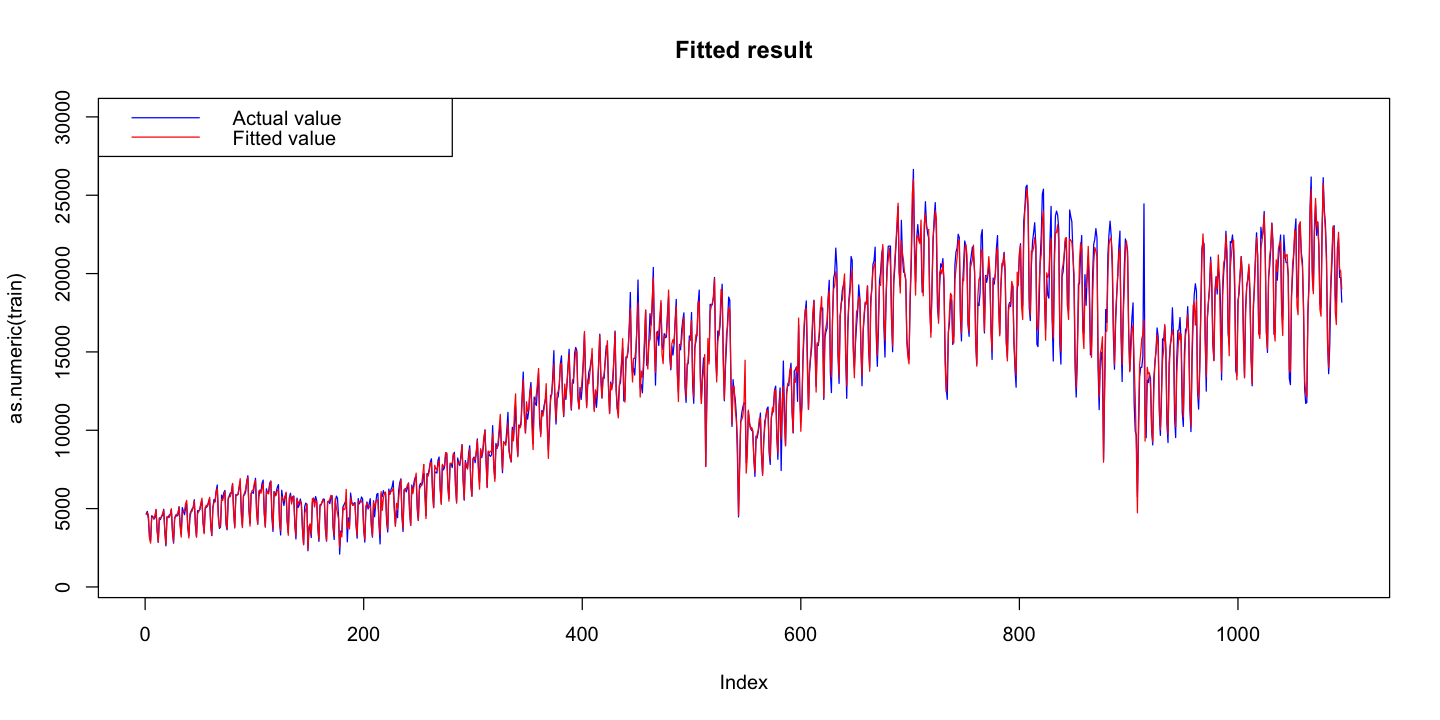

In [347]:
fitted_values <- as.numeric(residuals.bsts(model_log_opti, mean.only=TRUE)) + as.numeric(train_log)
train_hat <- exp(fitted_values) - 1
plot(as.numeric(train), type = "l", col = "blue", ylim=c(500, 30000), main="Fitted result")
lines(train_hat, col = "red")
legend("topleft", legend = c("Actual value", "Fitted value"), col = c("blue", "red"), lty = c(1, 1), lwd = c(1, 1))

<div class="alert alert-block alert-info"> 
While there's still patterns in the residual, it has zero means<br>
The ACF plot suggest there are minor autocorrelation in the first few lags</div>

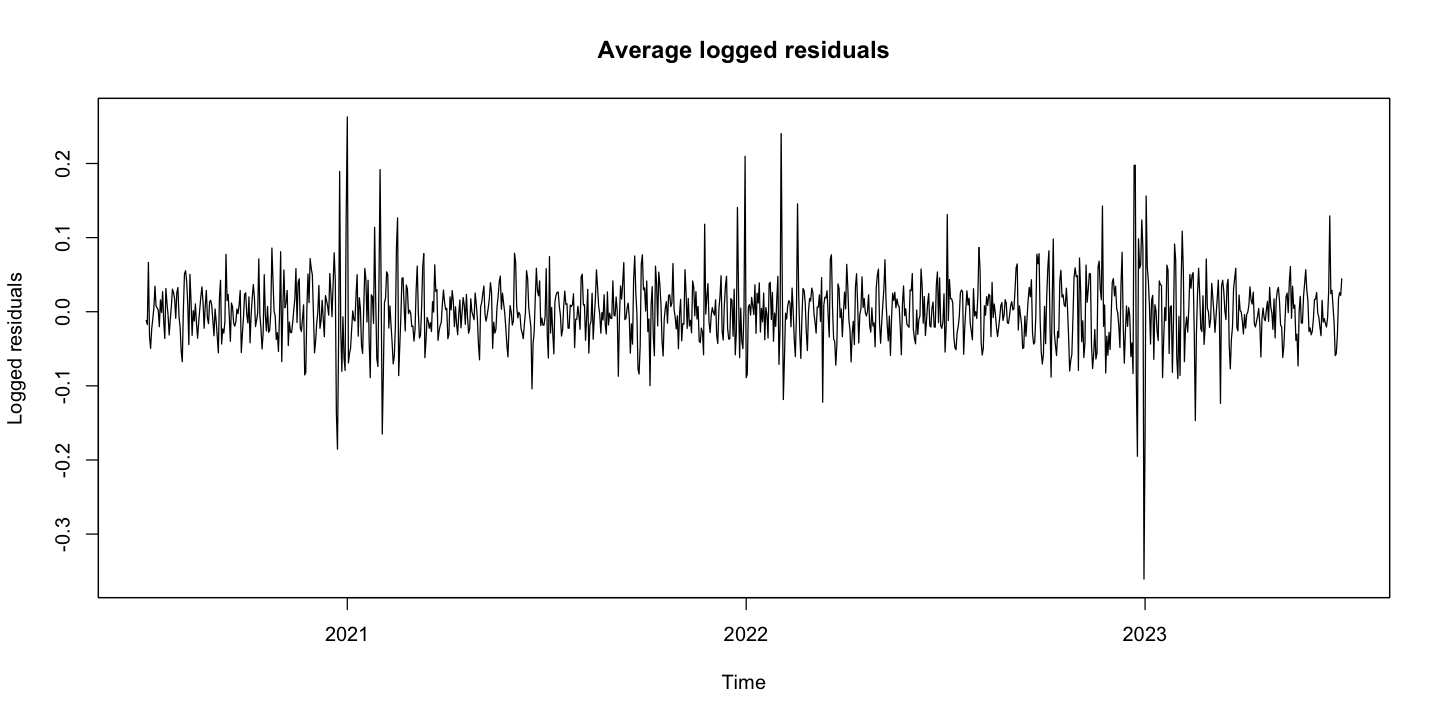

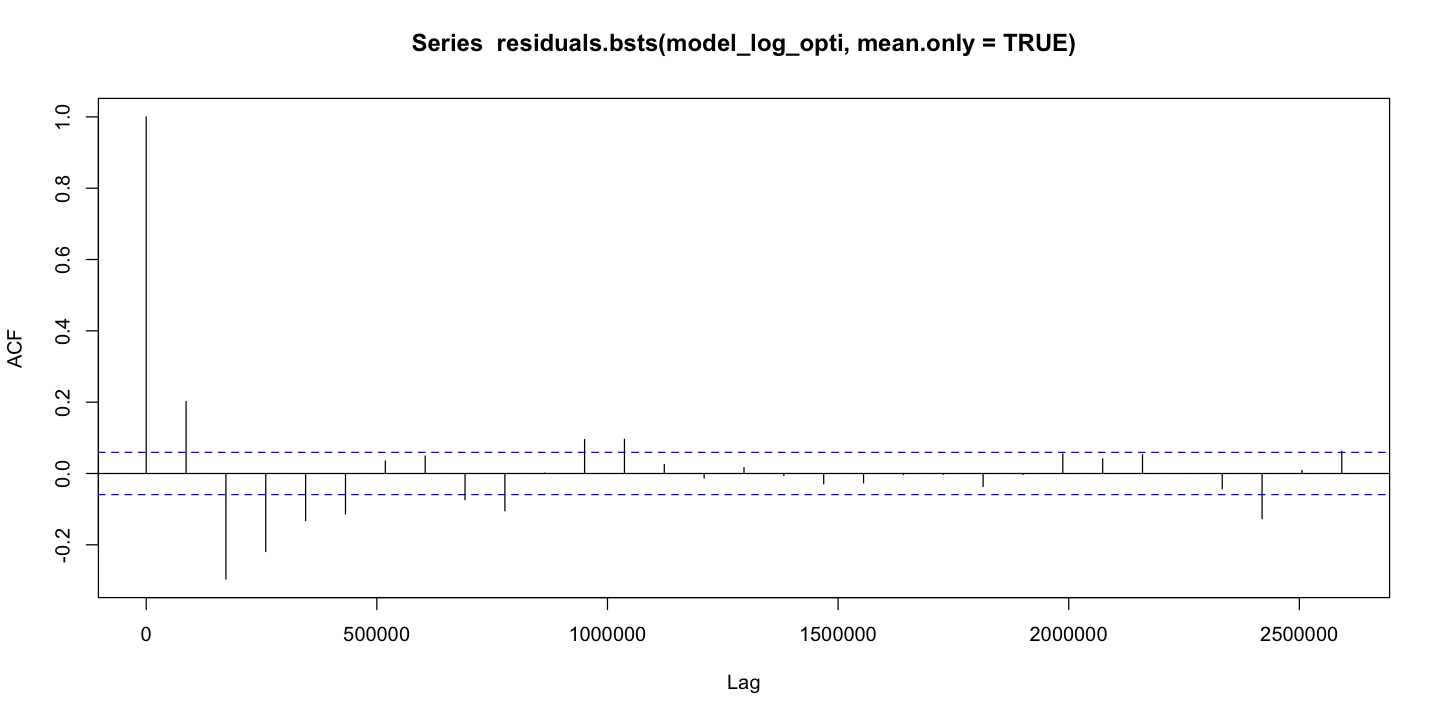

In [348]:
plot(residuals.bsts(model_log_opti, mean.only=TRUE), xlab="Time", ylab="Logged residuals", main="Average logged residuals")
acf(residuals.bsts(model_log_opti, mean.only=TRUE))

In [349]:
mean(residuals.bsts(model_log_opti, mean.only=TRUE))

[1] 6.078026e-05

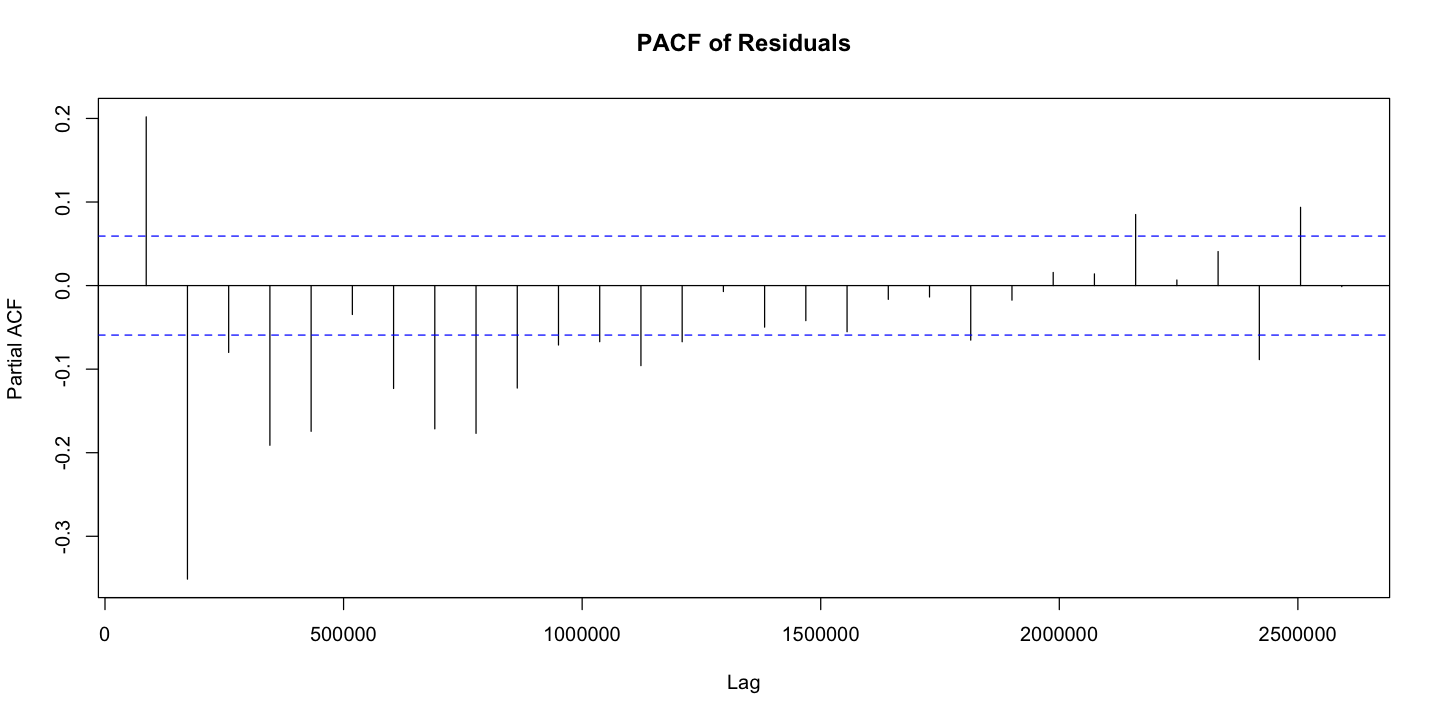

In [350]:
pacf(residuals.bsts(model_log_opti, mean.only=TRUE), main = "PACF of Residuals")

In [351]:
saveRDS(model_log_opti, file = "final_model.rda")

### Forecast

<div class="alert alert-block alert-info"> 
The forecast showed that the model successfully capture the seasonality and the holiday event</div>

In [340]:
horizon <- length(test)
pred_log_opti <- predict(model_log_opti, horizon = horizon, burn = SuggestBurn(.1, ss))
forecast_values_log_opti <- exp(pred_log_opti$mean) - 1
paste("RMSE: ", sqrt(mean((forecast_values_log_opti - test)^2)))

[1] "RMSE:  1980.49615037439"

In [342]:
paste("MAPE: ", mean(abs((forecast_values_log_opti-test)/test)) * 100)

[1] "MAPE:  9.76265710800389"

In [344]:
paste("MAE: ", mean(abs(forecast_values_log_opti-test)))

[1] "MAE:  1607.64117075642"

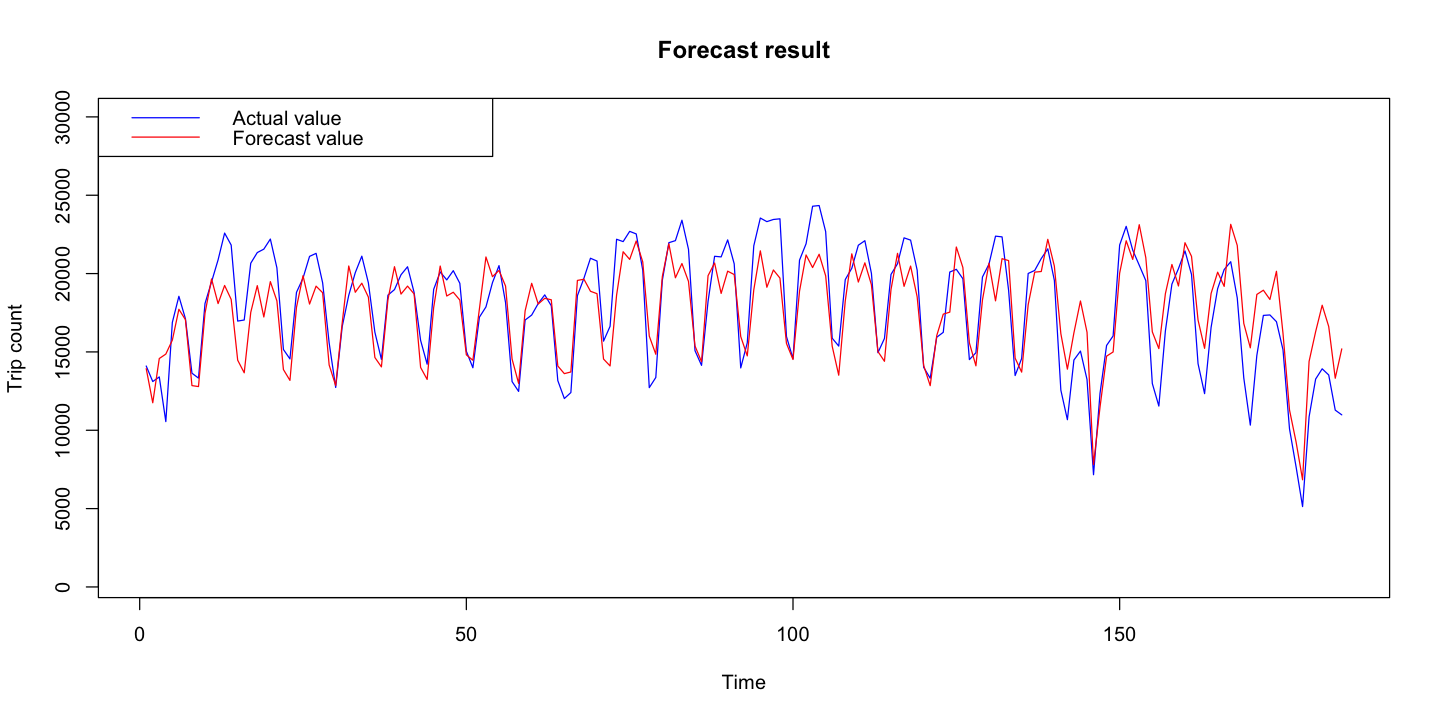

In [353]:
plot(as.numeric(test), type = "l", col = "blue", ylim=c(500, 30000), main="Forecast result", xlab="Time", ylab="Trip count")
lines(forecast_values_log_opti, col = "red")
legend("topleft", legend = c("Actual value", "Forecast value"), col = c("blue", "red"), lty = c(1, 1), lwd = c(1, 1))

### Holiday effect

<div class="alert alert-block alert-info"> 
The day before major national holidays usually have lower demand<br> While the events didn't increase the demand as I assume in the hypothesis</div>

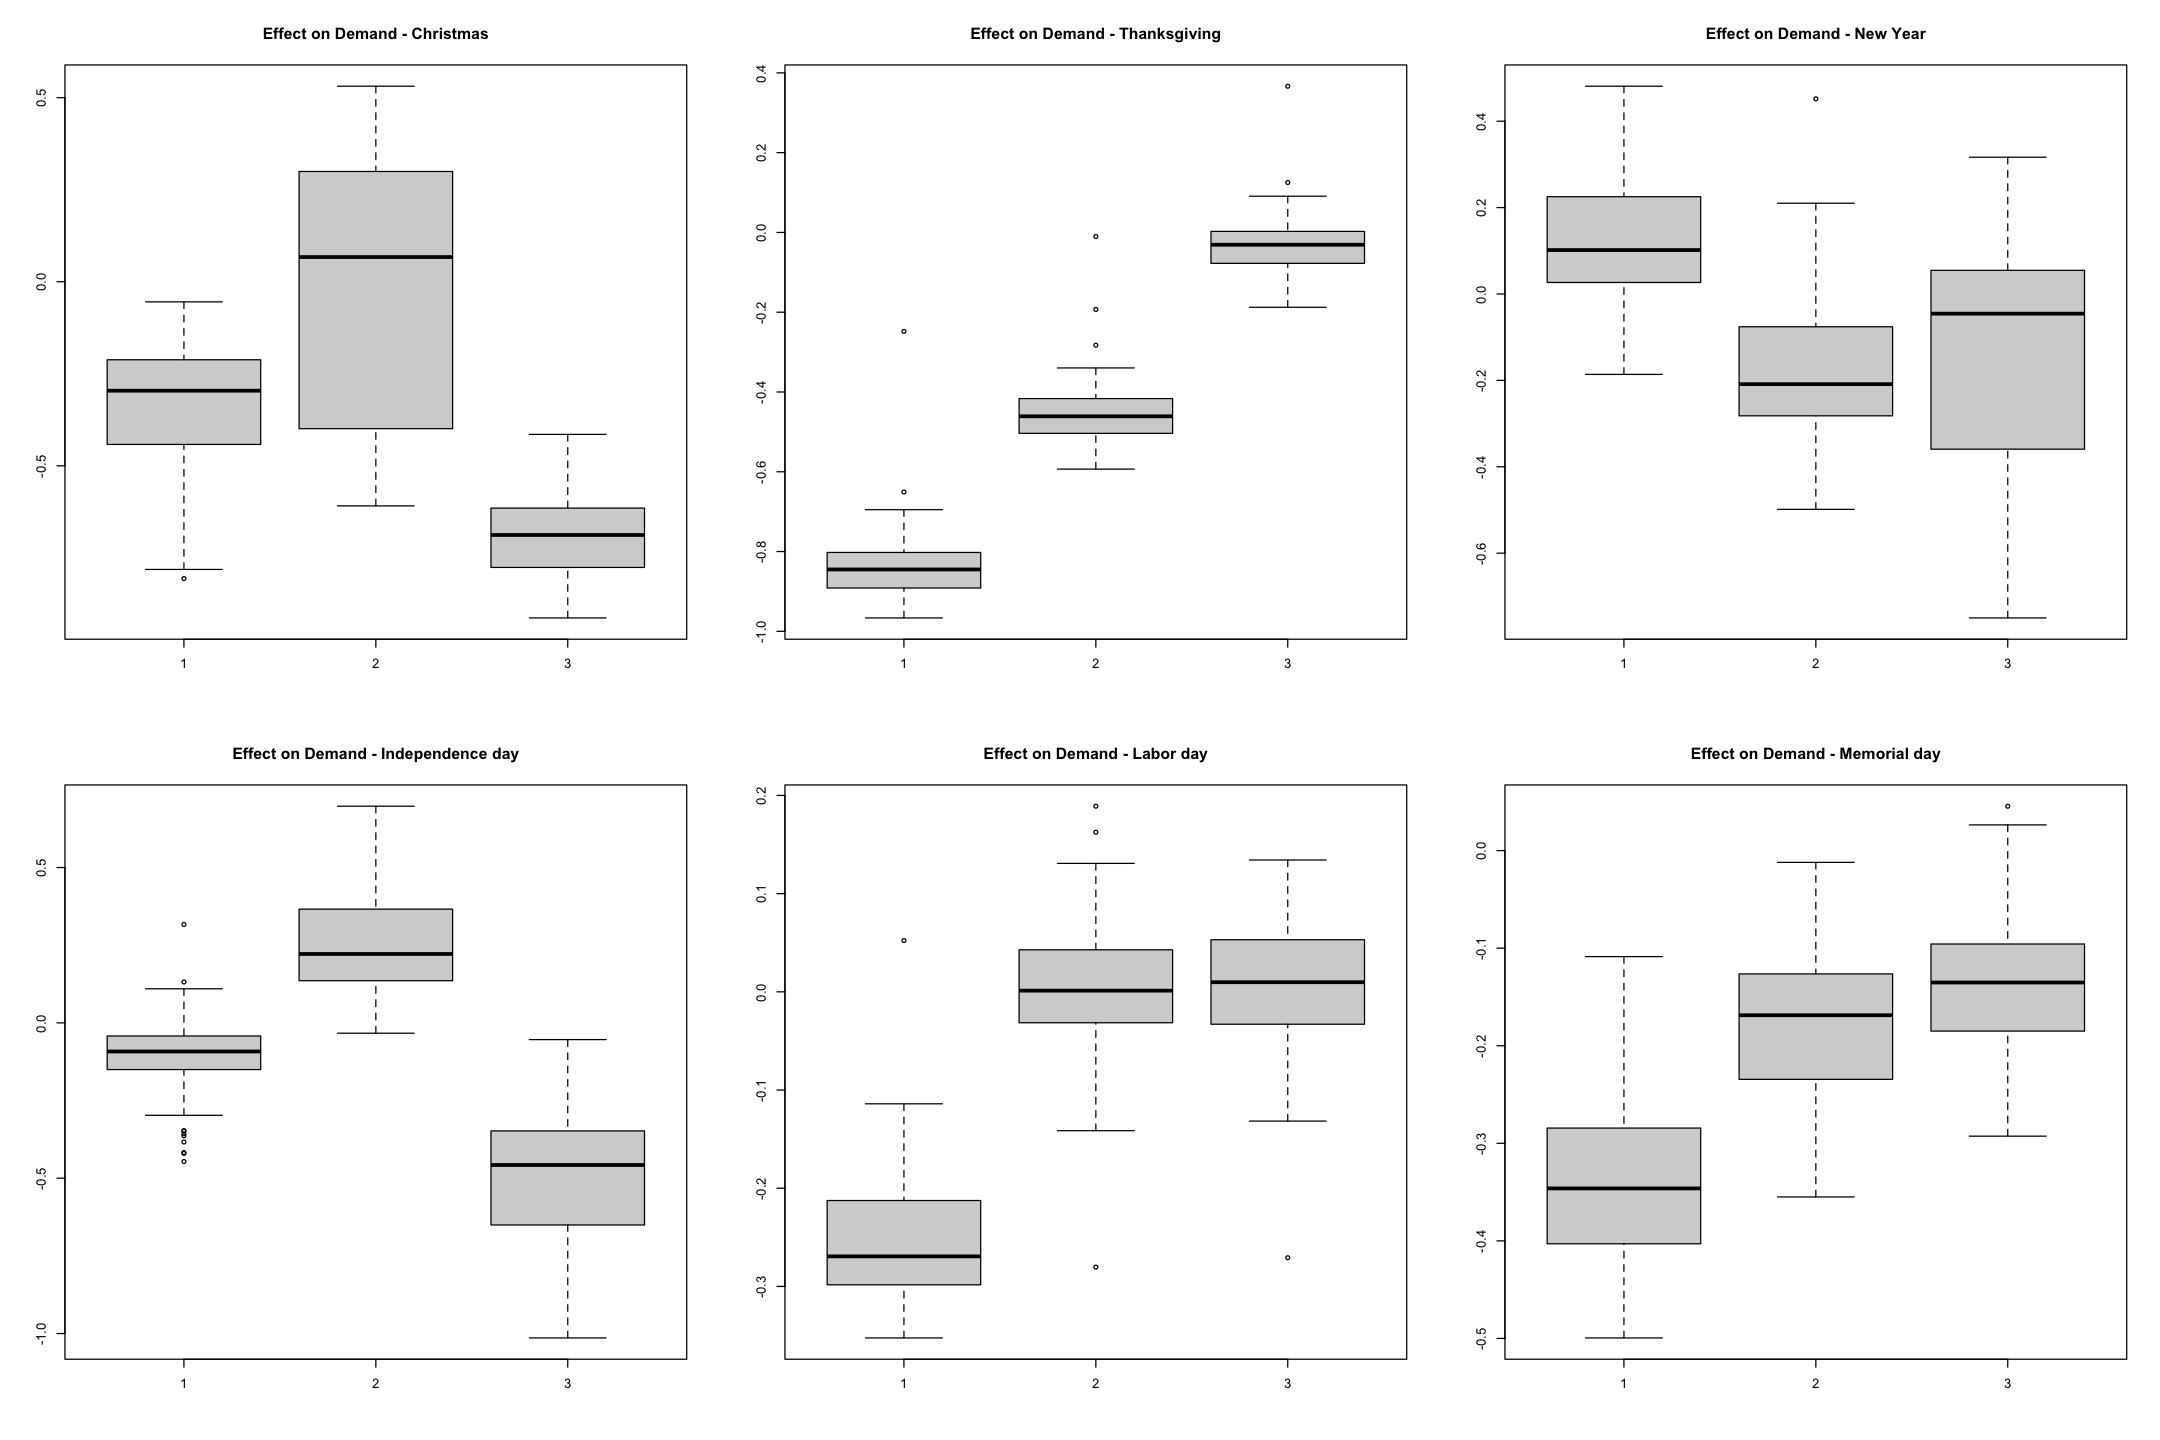

In [354]:
options(repr.plot.width=18, repr.plot.height=12)
par(mfrow=c(2,3))
PlotHoliday(christmas, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Christmas")
PlotHoliday(thanksgiving, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Thanksgiving")
PlotHoliday(new_year, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - New Year")
PlotHoliday(independence_day, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Independence day")
PlotHoliday(labor_day, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Labor day")
PlotHoliday(memorial_day, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Memorial day")

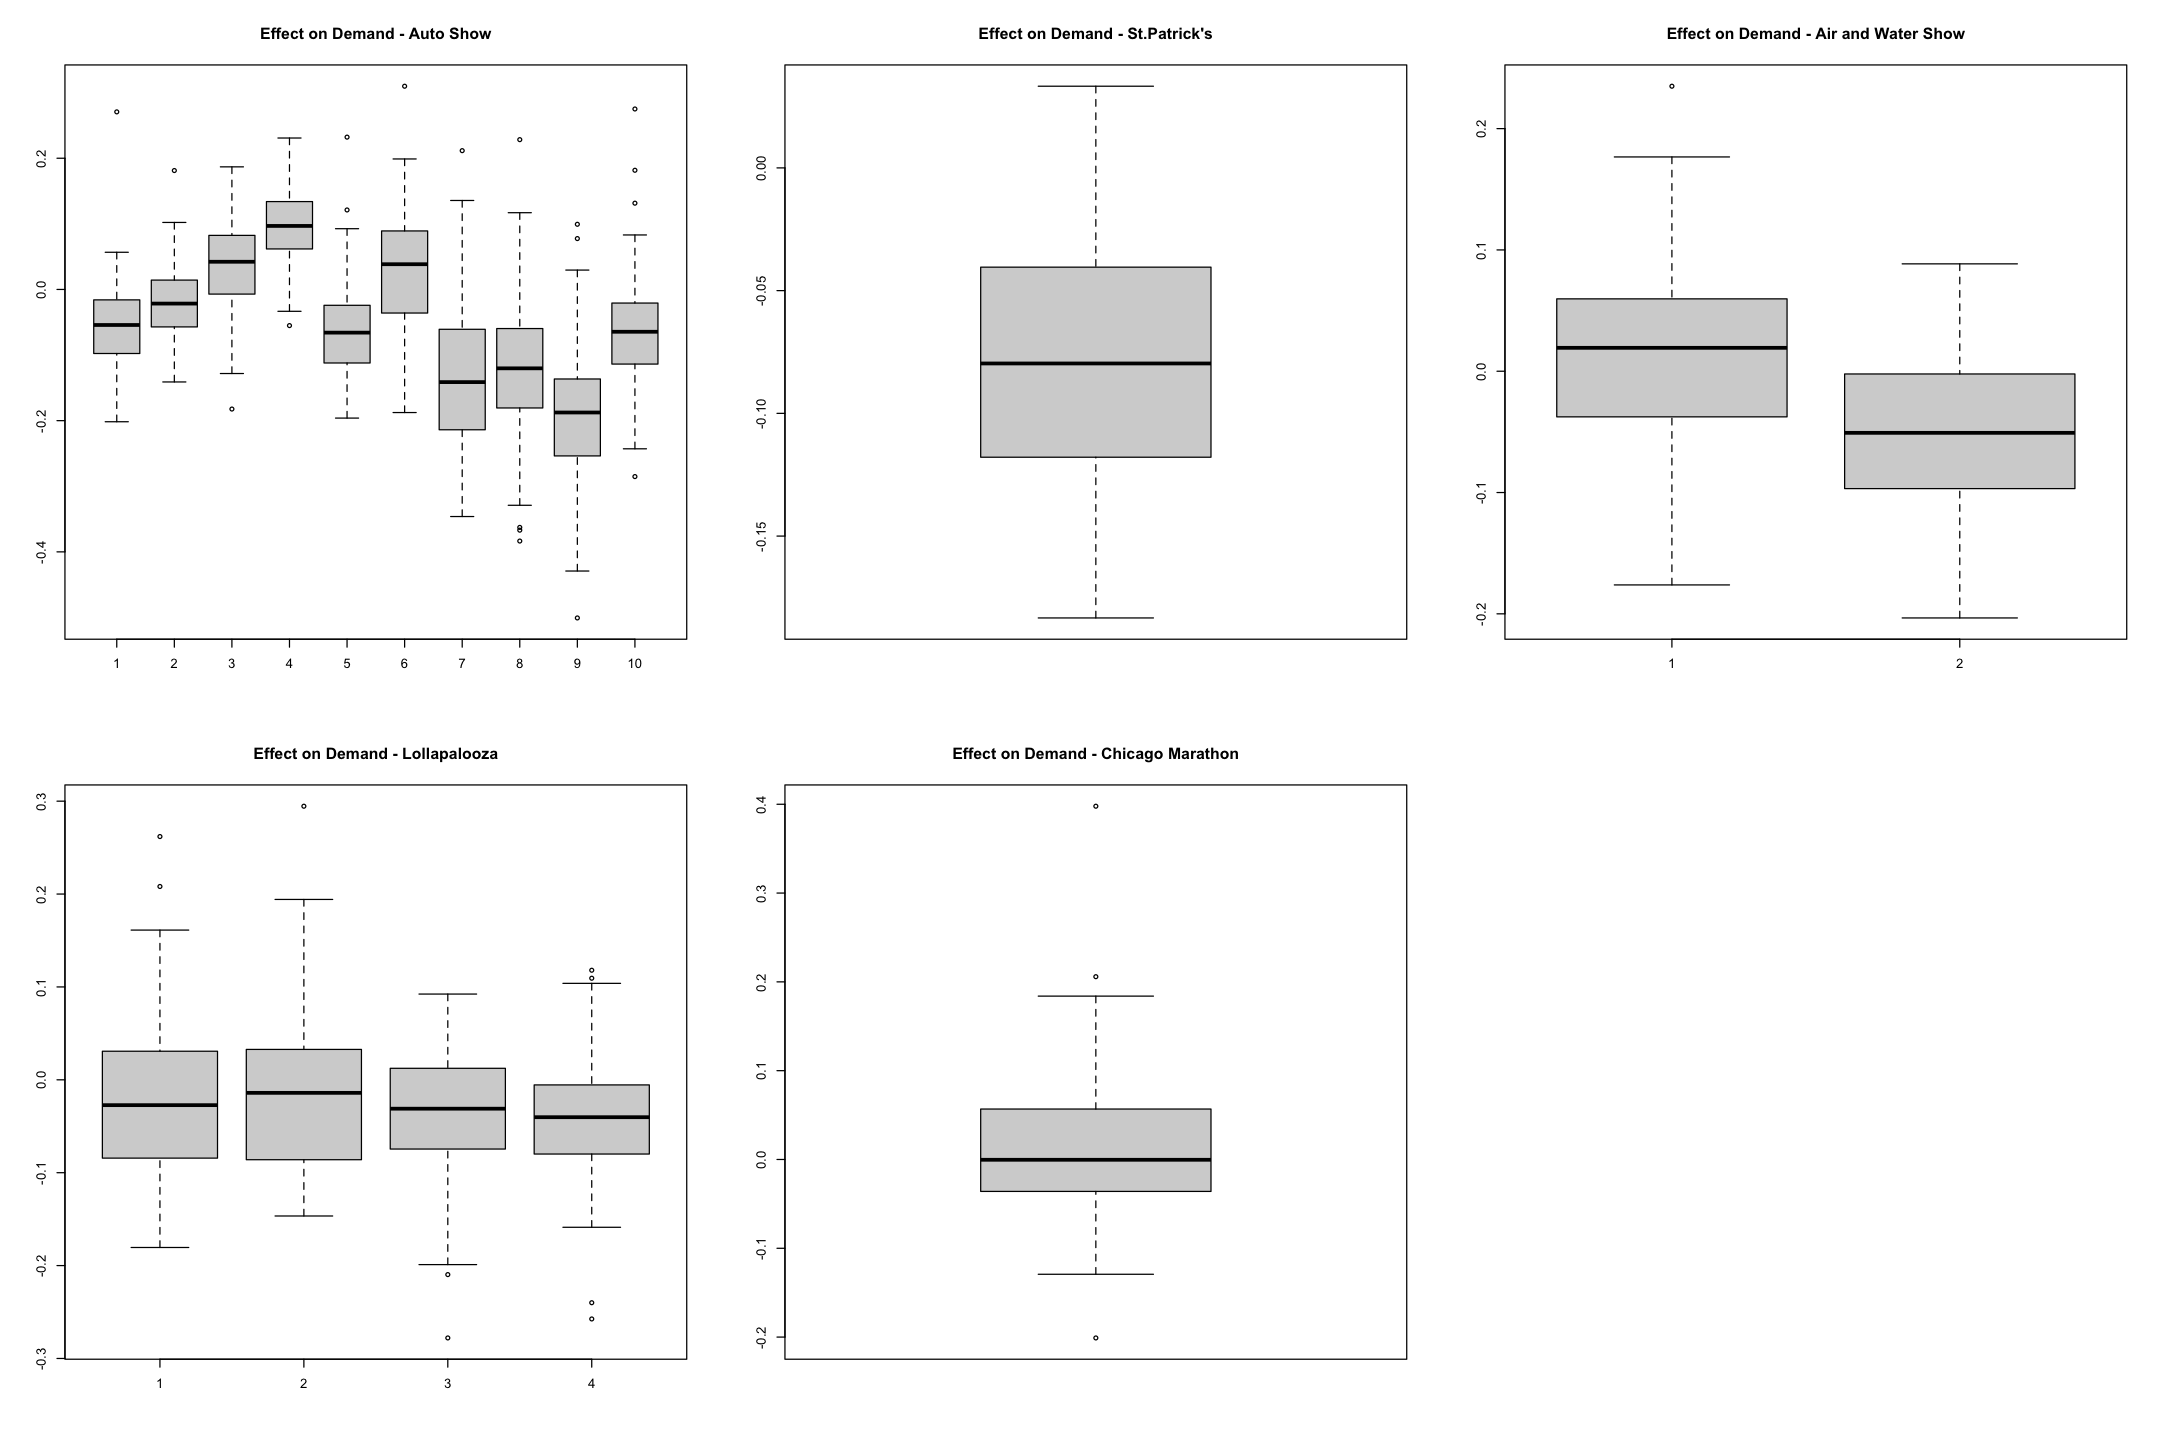

In [355]:
options(repr.plot.width=18, repr.plot.height=12)
par(mfrow=c(2,3))
PlotHoliday(auto.show, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Auto Show")
PlotHoliday(st.patrick, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - St.Patrick's")
PlotHoliday(air.show, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Air and Water Show")
PlotHoliday(lolla, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Lollapalooza")
PlotHoliday(marathon, model_log_opti,   show.raw.data=FALSE, main="Effect on Demand - Chicago Marathon")